# TP 3 - Planning (November 30)


![ChessUrl](https://gymnasium.farama.org/_images/frozen_lake.gif "Frozen Lake")

In this assignement, we focus on algorithms that require a **model** of the environment behavior. You will implement :

- A Monte Carlo Tree Search Algorithm
- A Tabular Dyna-Q Algorithm

You will be evaluated on:
* Implementation of the agents. Points will be granted to clean, scalable code.
* A Paragraph of analysis of the behavior of the algorithms . 

Send this notebook  to cyriaque.rousselot@inria.fr before next course.


In [816]:
%load_ext autoreload
%autoreload 1
%aimport utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment

### Snapshots

For the sake of planning algorithm, we will introduce the possibility of taking snapshots of the environment. Snapshots allows to return to a previously visited state.

In [817]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import utils 
from IPython.display import Image, display
import cv2  
import imageio, os
import seaborn as sns
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout



In [818]:
sns.set_style("whitegrid")

In [819]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                             render_mode="ansi",
                             max_episode_steps=200))
env.reset()
n_actions = env.action_space.n
n_states = env.observation_space.n

In [820]:
import matplotlib.pyplot as plt
print("initial_state:")
print(env.render())
# plt.axis('off')
env.close()

# create first snapshot
snap0 = env.get_snapshot()

initial_state:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [821]:
while True:
    _, _, terminated, truncated, _ = env.step(env.action_space.sample())
    if terminated:
        print("Whoops! We died!")
        break
    if truncated:
        print("Time is over!")
        break

print("final state:")
print(env.render())
env.close()

Whoops! We died!
final state:
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



/Users/razvanip/miniconda3/envs/rl_env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [822]:
# reload initial state
env.load_snapshot(snap0)

print("After loading snapshot")
print(env.render())
env.close()

After loading snapshot

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



## Monte Carlo Tree Search

https://en.wikipedia.org/wiki/Monte_Carlo_tree_search ; Sutton-Barto Chapter 8.11

The MCTS algorithm we will implement can be divided in 4 steps:
- Selection 
- Expansion
- Simulation
- Backpropagation

The first step is exploring the current tree using a UCB-1 rule until we get to a leaf L .

The second is creating a child C from feasable moves after the leaf L if the game is not finished.

The third is simulating the end of the game with an unbiased method to get an estimate of the value of the position C.

The fourth is updating the value estimation of the position of all nodes visited during the exploration of the tree.



![image.png](https://i.postimg.cc/6QmwnjPS/image.png)

We will use snapshots to simulate the effect of a sample model:
1. Saving a snapshot of state S
2. sending S,A to the environement
3. Getting back R and S'
4. When needed, loading the snapshot of state S

## Building the agent:

> Fill the blanks in the code

In [823]:
class Node:
    """A node in the Monte Carlo Tree Search (MCTS) algorithm."""
    
    #metadata:
    parent = None          #parent Node
    qvalue_sum = 0.         #sum of state values from all visits (numerator)
    times_visited = 0      #counter of visits (denominator)

    def __init__(self, parent, action):
        """
        Initializes a tree node with a parent, action, and environment.

        :param parent: parent TreeNode
        :param action: action to commit from parent Node
        """

        self.parent = parent
        self.action = action
        self.children = []



        result = env.get_result(parent.snapshot, action)
        (
            self.snapshot,
            self.observation,
            self.immediate_reward,
            self.is_done,
            _,
            _
        ) = result

    def is_leaf(self):
        return not self.children

    def is_root(self):
        return self.parent is None

    def get_qvalue_estimate(self):
        if self.times_visited !=0:
            return self.qvalue_sum / self.times_visited
        return 0

    def ucb_score(self, scale=10, max_value=float("inf")):
        """
        Computes the Upper Confidence Bound (UCB) score for the node.

        :param scale: Multiplies the upper bound by this value. Assumes reward range to be [0, scale].
        :param max_value: a value representing infinity (for unvisited nodes).
        """
        if self.times_visited == 0:
            return max_value

        ## To Complete

        mu = self.get_qvalue_estimate()
        N = self.parent.times_visited
        n = self.times_visited

        return mu + scale * np.sqrt(np.log(N) / n)


    def select_best_child(self):

        # Select the child with the highest UCB score
        best_child = max(self.children, key=lambda child: child.ucb_score())
        return best_child


    # MCTS steps

    def select_best_leaf(self):
        """
        Selects the leaf with the highest priority to expand.

        Recursively picks nodes with the best UCB score until it reaches a leaf.
        """
        # Using the UCB valuation, select the best possible child among children of a node
        if self.is_leaf():
            return self
        children = self.children
        
        best_child = max(children, key=lambda child: child.ucb_score())
        return best_child.select_best_leaf()

    def expand(self):
        """
        Expands the current node by creating all possible child nodes.

        Returns one of those children.
        """
        # You can't generate a child if there is already an existing child with the same associated action.

        assert not self.is_done, "Can't expand from terminal state"

        self.children = [Node(self, action) for action in range(n_actions)]

        return self.select_best_leaf()

    

    def rollout(self, t_max=10**4):
        """
        Plays the game from this state to the end (done) or for t_max steps.

        On each step, picks an action at random.

        Computes the sum of rewards from the current state until the end of the episode.

        If the node is terminal, return the immediate reward
        """


        # Your code for performing rollout and computing reward goes here
        env.load_snapshot(self.snapshot)
        obs = self.observation
        is_done = self.is_done

        rollout_reward = 0
        time_spent = 0

        while not is_done and time_spent < t_max:
            
            # Randomly sample an action from the action space
            action = env.action_space.sample()
            
            # Perform the action
            obs, reward, is_done, truncated, info = env.step(action)
            
            # Update the total reward
            rollout_reward += reward
            
            # Update the time spent
            time_spent += 1

  

        return rollout_reward

    def propagate(self, child_qvalue):
        """
        Uses the child Q-value to update parents number of visits and qvalue recursively.
        """
        my_qvalue = self.immediate_reward + child_qvalue

        # Update qvalue_sum and times_visited
        self.qvalue_sum += my_qvalue
        self.times_visited += 1

        # Propagate upwards
        if not self.is_root():
            self.parent.propagate(my_qvalue)
    def safe_delete(self):
        """safe delete to prevent memory leak in some python versions"""
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child

    def __str__(self):
        return f"{self.observation}\nq:{self.get_qvalue_estimate():.3f}"

    def __repr__(self):
        return self.__str__()

In [824]:
class Root(Node):
    """The root node"""

    def __init__(self, snapshot, observation):
        self.parent = self.action = None
        self.children = []
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False

    @staticmethod
    def from_node(node):
        root = Root(node.snapshot, node.observation)
        # Copy data
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root


In [825]:
class LakeNode(Node): 

    def __init__(self, parent, action):
        super().__init__(parent, action)


        #If you go to left, you can't go to right (it wouldn't make sense), if you go up, you don't go down, etc.
        if self.parent is not None:
            self.forbbiden_move = (action + 2) % 4

        self.depth = self.parent.depth + 1 if self.parent is not None else 0


    def expand(self):
        """
        Expands the current node by creating all possible child nodes.

        Returns one of those children.
        """
        # You can't generate a child if there is already an existing child with the same associated action.

        assert not self.is_done, "Can't expand from terminal state"


        if self.children == []:
            for action in range(n_actions):
                
                #avoid the forbbiden move
                if self.parent is not None and action == self.forbbiden_move:
                    continue

                child = LakeNode(self, action)

                #avoid the actions which lead to the same state
                if child.observation != self.observation:  
                    self.children.append(child)

        return self.select_best_leaf()


In [826]:
class LakeRoot(LakeNode): 
    """The root node"""

    def __init__(self, snapshot, observation):
        self.parent = self.action = None
        self.children = []
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False
        self.depth = 0

    @staticmethod
    def from_node(node):
        root = LakeRoot(node.snapshot, node.observation)
        # Copy data
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root

### Running the MCTS 

In [827]:
def plan_mcts(root, n_iters=10):
    """
    Builds a tree with Monte-Carlo Tree Search for n_iters iterations.
    :param root: Tree node to plan from.
    :param n_iters: Number of select-expand-simulate-propagate loops to make.
    """
    for _ in range(n_iters):
        # print("MCTS iteration", _)
        node = root.select_best_leaf()

        if node.is_done:
            # All rollouts from a terminal node are empty, and thus have 0 reward.
            node.propagate(0)
        else:
            # Expand the best leaf, perform a rollout from it, and propagate the results upwards.
            # Expand the best leaf to get a new child
            new_child = node.expand()

            # Perform a rollout from the new child
            child_reward = new_child.rollout()

            new_child.propagate(child_reward)          

> Use the MCTS implementation to find the optimal policy and show it. Bonus point will be given to a clear display

In [828]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                             render_mode="ansi",
                             max_episode_steps=200, is_slippery=False))
root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = LakeRoot(root_snapshot, root_observation[0])

## It is possible to finish the IceLake with only one planning (if we are lucky)

In [829]:
plan_mcts(root, n_iters=30000)

In [830]:
def play_a_game_one_tree(root): 

    moves = {
        0 : "L",
        1 : "D",
        2 : "R",    
        3 : "U",
    }

    env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",render_mode="ansi",max_episode_steps=200))

    states = []
    actions = []

    env.load_snapshot(root.snapshot)
    env.render()
    is_done = False
    node = root
    

    while not is_done:
        best_child = max(node.children, key=lambda child: child.get_qvalue_estimate())

        states.append(node.observation)
        actions.append(best_child.action)
        print("Taking action {} (value={})".format(moves[best_child.action], best_child.get_qvalue_estimate()))
        _, _, is_done, _, _ = env.step(best_child.action)
        env.render()
        node = best_child

    print("Finished")

    return states, actions

In [831]:
states, actions = play_a_game_one_tree(root)

Taking action R (value=0.003116297573266145)
Taking action R (value=0.00434610825760569)
Taking action R (value=0.005760670332547788)
Taking action R (value=0.00932642487046632)
Taking action R (value=0.014344262295081968)
Taking action R (value=0.018329938900203666)
Taking action R (value=0.028112449799196786)
Taking action D (value=0.028112449799196786)
Taking action D (value=0.047619047619047616)
Taking action D (value=0.09230769230769231)
Taking action D (value=0.17647058823529413)
Taking action D (value=0.3333333333333333)
Taking action D (value=0.6)
Taking action D (value=1.0)
Finished


In [832]:
def build_lake_path(states, actions): 

    sns.set_style("white")

    iced_lake = np.full((64), -1)
    iced_lake[states] = actions
    iced_lake = iced_lake.reshape((8,8))

    moves = {
        0 : "L",
        1 : "D",
        2 : "R",
        3 : "U",
    }


    plt.title("The optimal path")
    plt.imshow(iced_lake, cmap="cool")

    for i in range(8):
        for j in range(8):
            if iced_lake[i][j] == -1:
                if i == 7 and j == 7:
                    plt.text(j, i, "End", ha="center", va="center", color="green")
                else:
                    plt.text(j, i, "", ha="center", va="center", color="black")
            else: 
                plt.text(j, i, moves[iced_lake[i][j]], ha="center", va="center", color="black")

    plt.show()

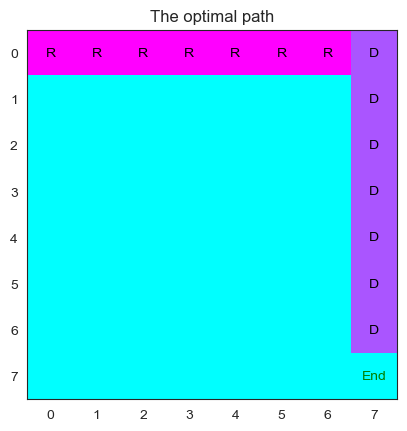

In [833]:
build_lake_path(states, actions)

In [834]:
def build_graph(G, node, add_children=True, skip_useles_path=False):


    moves = {
        0 : "L",
        1 : "D",
        2 : "R",
        3 : "U",
    }

    label = f"Q: {node.get_qvalue_estimate():.2f}\nVisits: {node.times_visited}"
    G.add_node(node, label=label)
    if node.parent:
        action_label = f"Action: {moves[node.action]}"
        G.add_edge(node.parent, node, label=action_label)


    
    if node.children and add_children:
        best_child = max(node.children, key=lambda child: child.get_qvalue_estimate())            
        build_graph(G, best_child, add_children=True, skip_useles_path=skip_useles_path)

        if not skip_useles_path:
            for child in node.children:
                if child != best_child:
                    build_graph(G, child, add_children=False, skip_useles_path=skip_useles_path)



In [835]:
G = nx.DiGraph()

build_graph(G,root)

#### The plot below is the graph of the optimal path. The plot displays only the nodes which are either a part of the optimal path or they are other possible actions from a state from the optimal path. It will always choose the node with the biggest relative qvalue

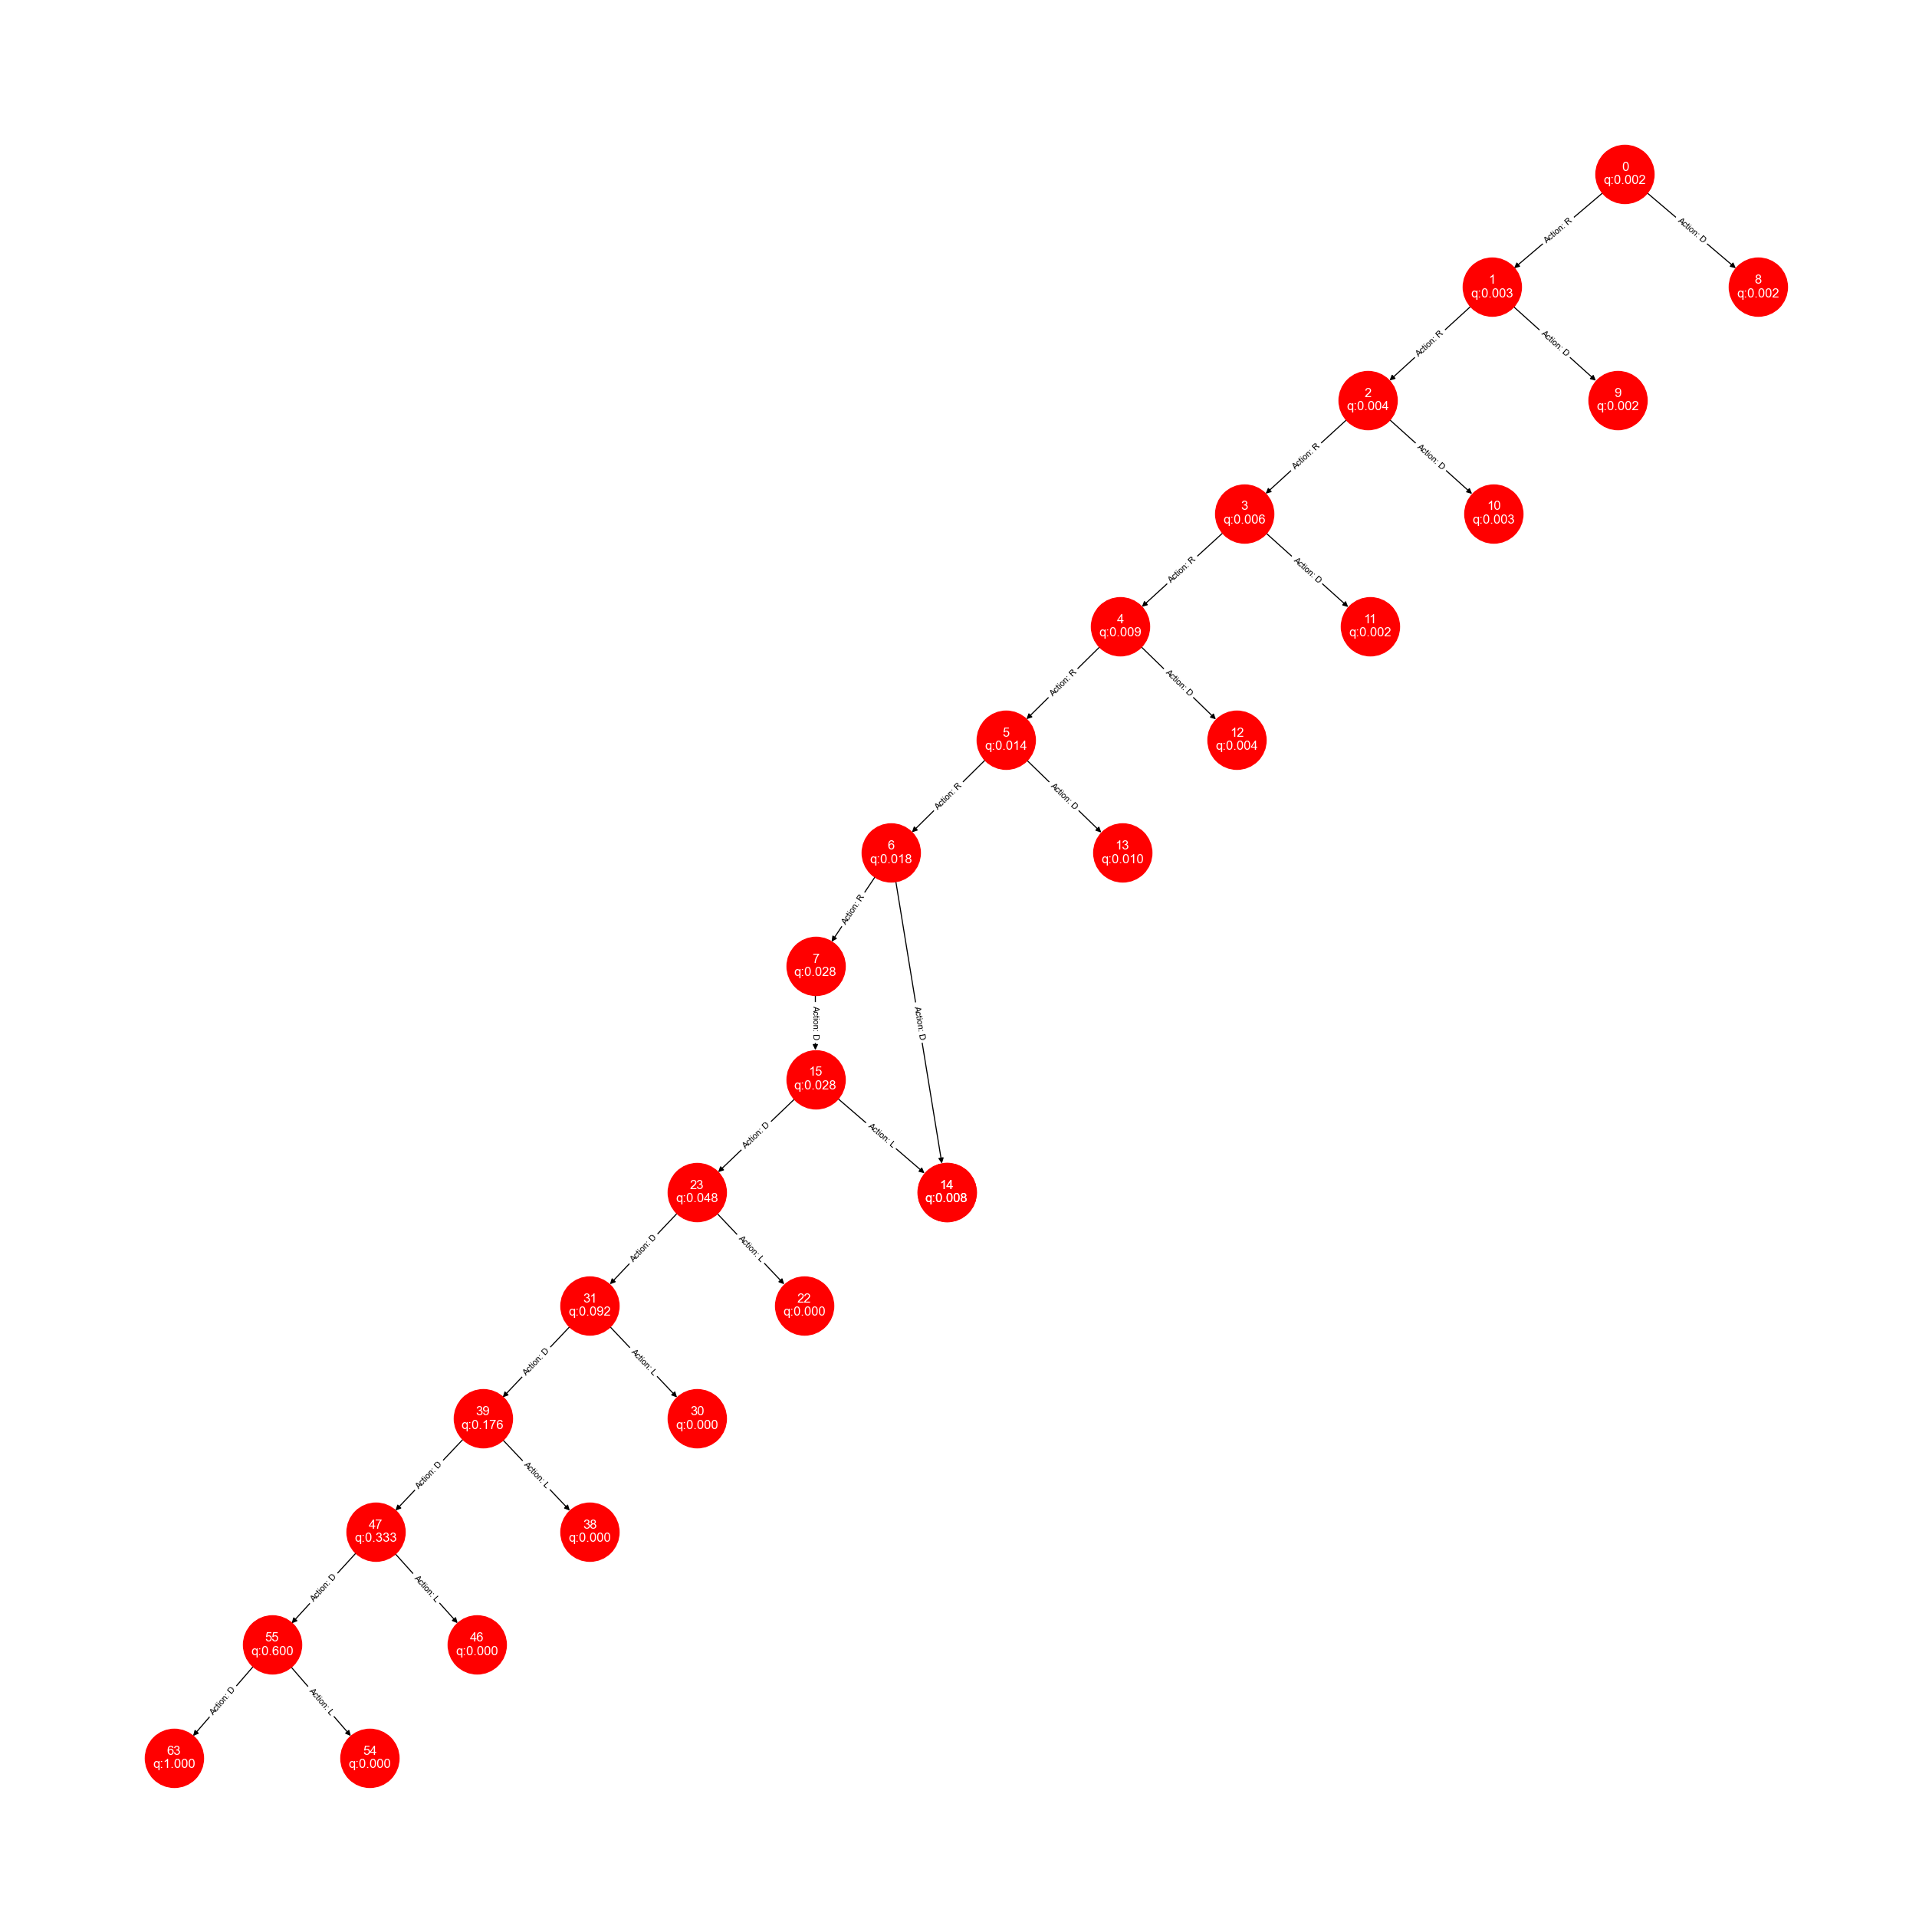

In [836]:
plt.figure(figsize=(25, 25))
pos = graphviz_layout(G, prog="dot",) 
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="red", font_color="white")
edge_labels = nx.get_edge_attributes(G, 'label', )
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='black')
plt.show()

## The IceLake standard MCTS procedure

In [837]:
def play_lake(root, n_iters=200):

    moves = {
        0 : "L",
        1 : "D",
        2 : "R",
        3 : "U",
    }

    states = []
    actions = []
    time_visited = []  

    while True:
        plan_mcts(root, n_iters=n_iters)


        env.load_snapshot(root.snapshot)
        best_child = max(root.children, key=lambda child: child.get_qvalue_estimate())
        action = best_child.action
        

        states.append(root.observation)
        actions.append(action)

        print(f"Observation {root.observation}, action {moves[action]}")

        next_state, _, is_done, _, _ = env.step(action)

        root = LakeRoot.from_node(best_child)

        if is_done:
            print("Finished")
            break

    return states, actions

In [908]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                             render_mode="ansi",
                             max_episode_steps=200, is_slippery=False))
root_observation = env.reset()
root_snapshot = env.get_snapshot()

root = LakeRoot(root_snapshot, root_observation[0])

In [909]:
states, actions = play_lake(root,n_iters=1000)

Observation 0, action R
Observation 1, action R
Observation 2, action R
Observation 3, action R
Observation 4, action R
Observation 5, action R
Observation 6, action R
Observation 7, action D
Observation 15, action D
Observation 23, action D
Observation 31, action D
Observation 39, action D
Observation 47, action D
Observation 55, action D
Finished


In [910]:
states = np.zeros((64))

def cound_states(node, states): 

    # print(node.observation)
    states[node.observation] += 1

    if node.is_leaf(): 
        return
    
    for child in node.children:
        cound_states(child, states)



cound_states(root, states)

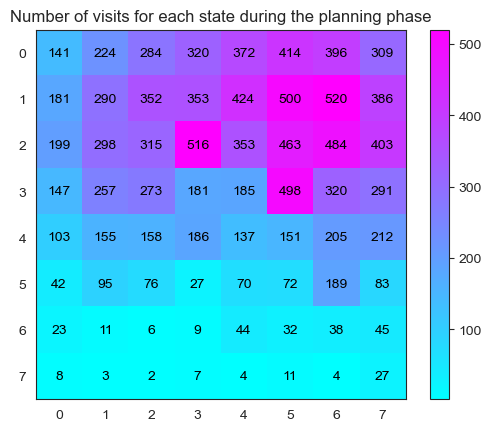

In [911]:
states = states.reshape(8,8)

plt.title("Number of visits for each state during the planning phase")
plt.imshow(states, cmap="cool")

for i in range(8):
    for j in range(8):
        plt.text(j, i, str(int(states[i, j])), ha="center", va="center", color="black")

plt.colorbar()
plt.show()


#### The plot below is the graph of the optimal path. The plot displays only the nodes which are either a part of the optimal path or they are other possible actions from a state from the optimal path. It will always choose the node with the biggest relative qvalue

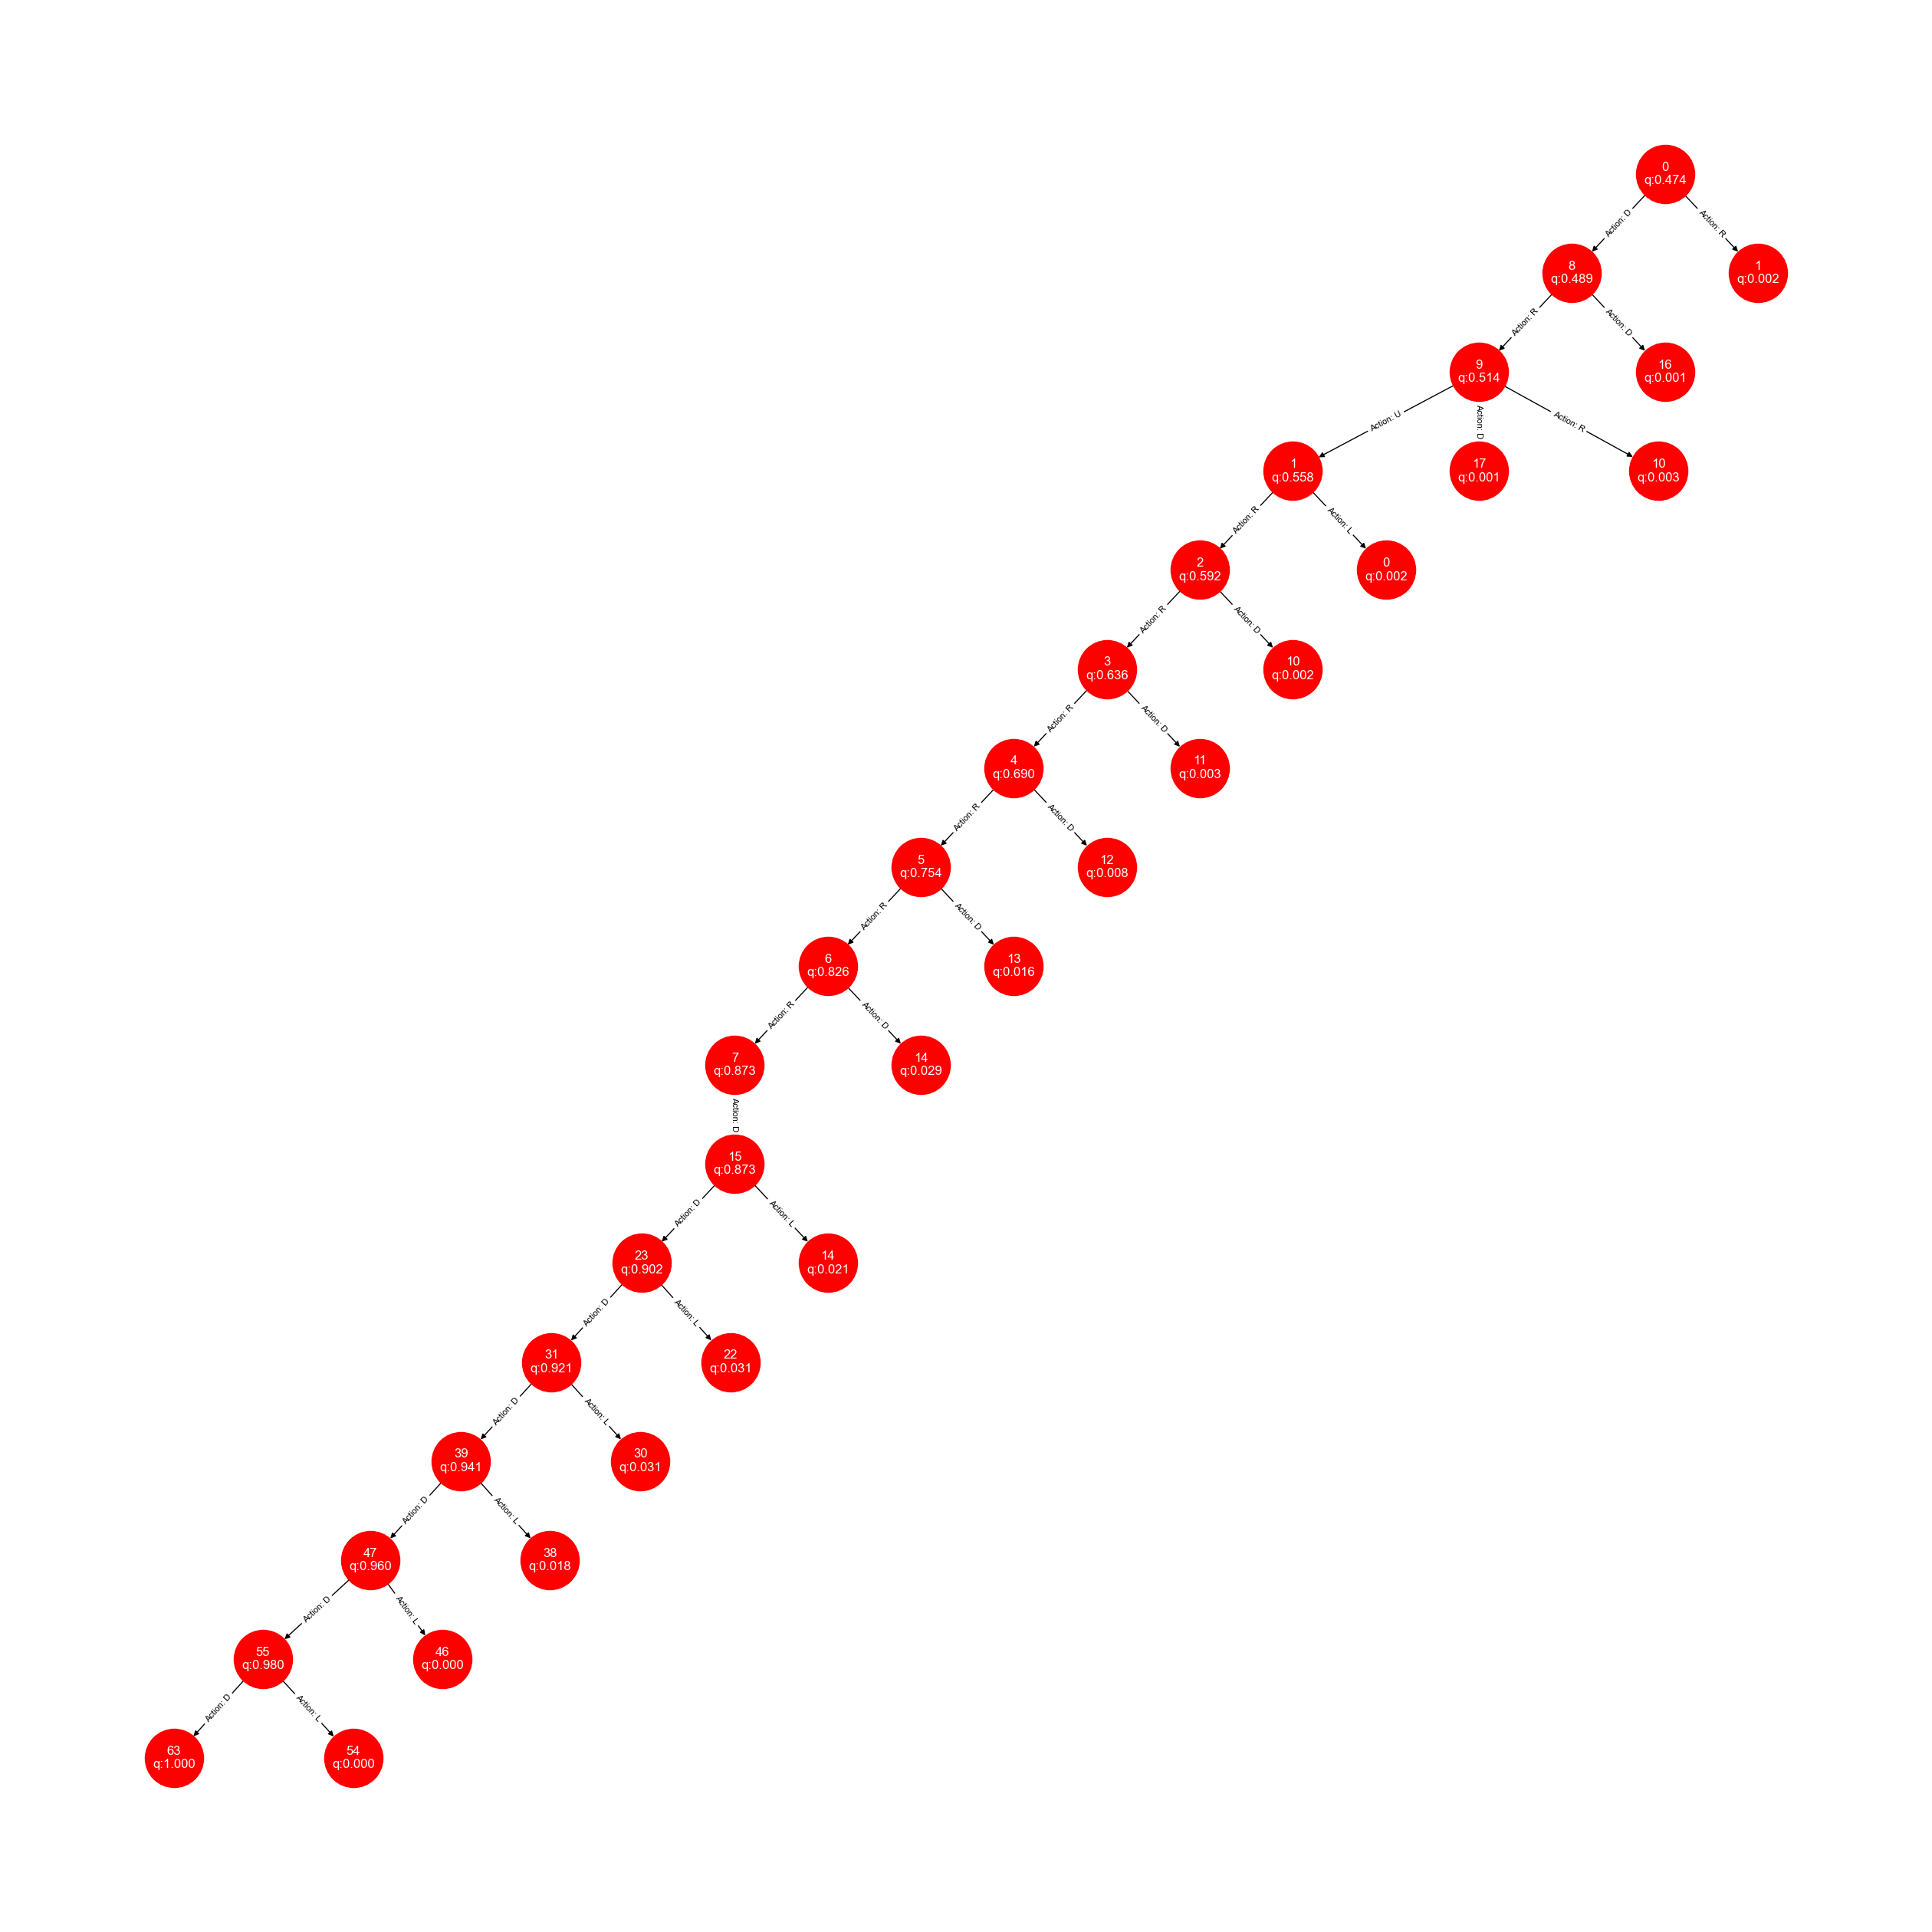

In [842]:
G = nx.DiGraph()


build_graph(G,root, add_children=True, skip_useles_path=False)


plt.figure(figsize=(25, 25))
pos = graphviz_layout(G, prog="dot",) 
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="red", font_color="white")
edge_labels = nx.get_edge_attributes(G, 'label', )
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='black')
plt.show()

> Try it also on the Cartpole problem:

In [843]:
class CartNode(Node): 

    def __init__(self, parent, action):
        super().__init__(parent, action)

    def expand(self):
        """
        Expands the current node by creating all possible child nodes.

        Returns one of those children.
        """
        # You can't generate a child if there is already an existing child with the same associated action.

        assert not self.is_done, "Can't expand from terminal state"

        # we have only two options
        self.children = [CartNode(self, action) for action in [0,1]]

        return self.select_best_leaf()

In [844]:
class CartRoot(CartNode): 
    """The root node"""

    def __init__(self, snapshot, observation):
        self.parent = self.action = None
        self.children = []
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False

    @staticmethod
    def from_node(node):
        root = CartRoot(node.snapshot, node.observation)
        # Copy data
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root

In [883]:
env = utils.WithSnapshots(gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=200))

root_observation, _ = env.reset()
root_snapshot = env.get_snapshot()
root = CartRoot(root_snapshot, root_observation)

In [884]:
def play_cart_pole(root, force_continue=False):
    images = []
    states =[]
    choices = []
    for n in range(5000):
        plan_mcts(root, n_iters=20) # simulate 10 steps 
        env.load_snapshot(root.snapshot) # reset the environment to the root state

        best_child = max(root.children, key=lambda child: child.get_qvalue_estimate())
        action = best_child.action
        root = CartRoot.from_node(best_child)
        state, reward, done, truncated, _ = env.step(action) # take the action


        images.append(env.render()) # save the image
        states.append(state)
        choices.append(action)

        if done:
            print('done')
            print('Iteration', n+1)
            break
        if truncated:
            print('Iteration', n+1)
            print('time is over')
            break

    return images, states, choices

In [885]:
images, states, choices = play_cart_pole(root, force_continue=False)

Iteration 200
time is over


In [886]:
def build_cartpole_gif(images):
    for i, img in enumerate(images):
        text = f"Move: {i+1}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        position = (10, 50) 
        font_scale = 1
        font_color = (8, 143, 143)
        line_type = 2

        img_with_text = cv2.putText(img.copy(), text, position, font, font_scale, font_color, line_type)
        images[i] = img_with_text
        
    gif_path = os.path.join(os.getcwd(), "cart_pole.gif")
    imageio.mimsave(gif_path, images, fps=10)

    return gif_path

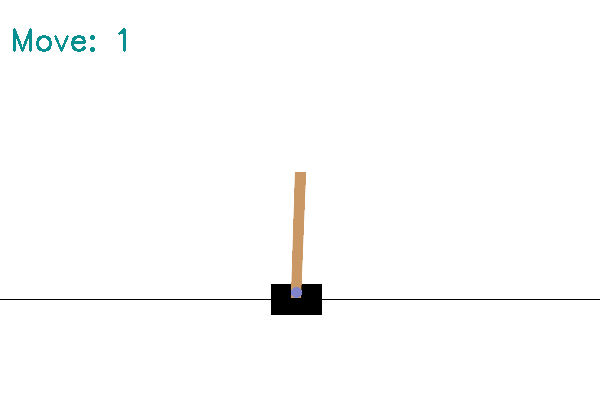

In [887]:
gif_path = build_cartpole_gif(images)

display(Image(filename=gif_path))

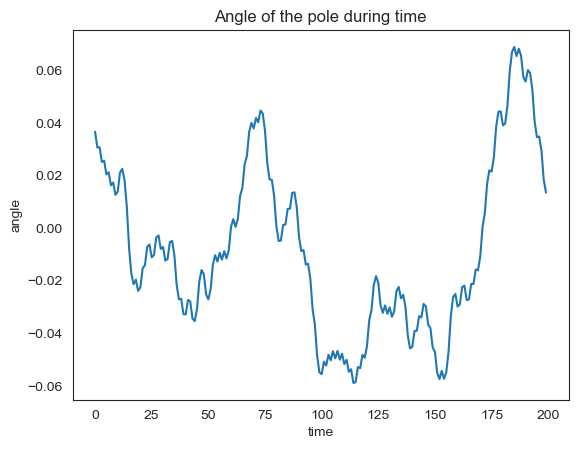

In [888]:
def plot_angle(states):

    angles = [state[2] for state in states]
    plt.plot(angles)
    plt.title('Angle of the pole during time')
    plt.xlabel('time')
    plt.ylabel('angle')
    plt.show()

plot_angle(states)

It seems that the agent is trying to balance the angle during the whole duration

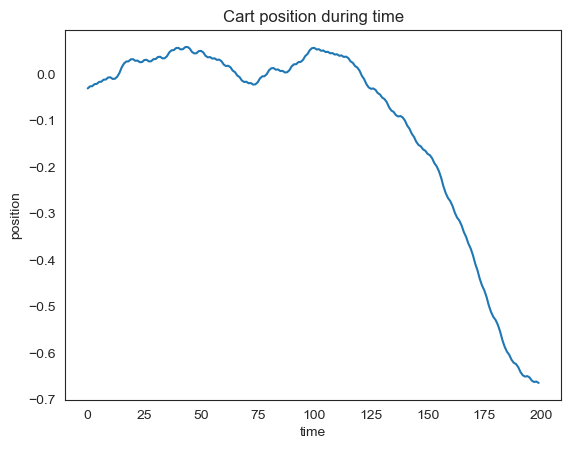

In [889]:
# Let's plot the cart position 

def plot_cart_position(states):
    cart_positions = [state[0] for state in states]
    plt.plot(cart_positions)
    plt.title('Cart position during time')
    plt.xlabel('time')
    plt.ylabel('position')
    plt.show()

plot_cart_position(states)

The cart gradually goes to the left side of the environment at the end of the episode

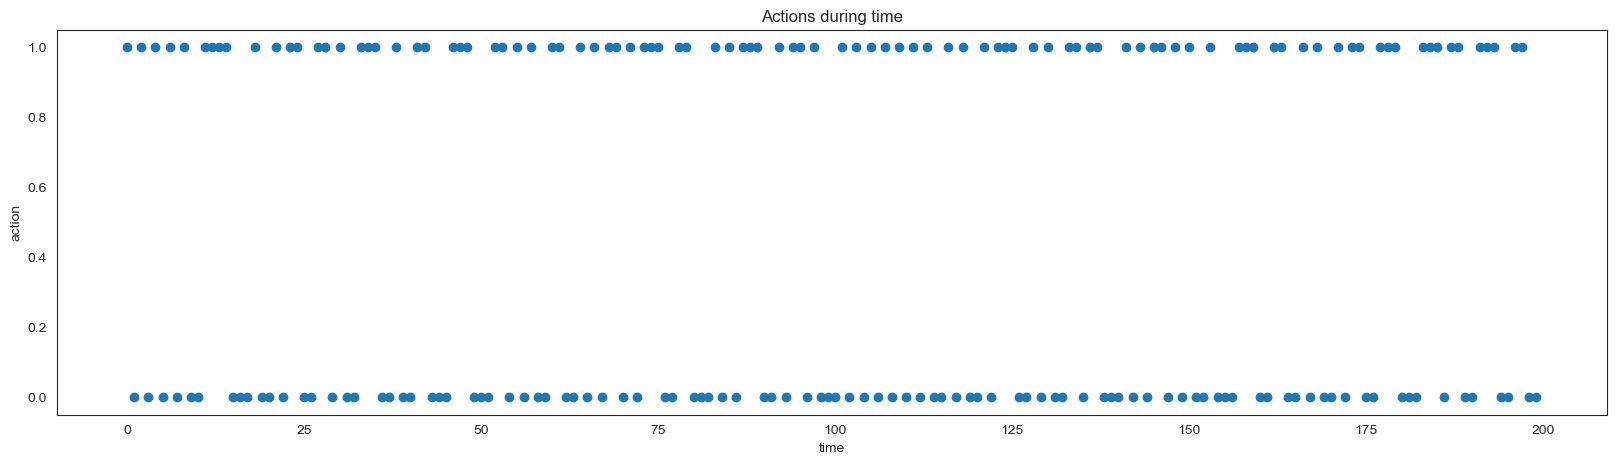

In [896]:
# Plot the actions 

def plot_actions(choices):
    plt.figure(figsize=(20, 5))
    plt.plot(choices, 'o')
    plt.title('Actions during time')
    plt.xlabel('time')
    plt.ylabel('action')
    plt.show()

plot_actions(choices)

Although it is not the best plot, it is more or less visible that each left move is followed by a right move and vice versa

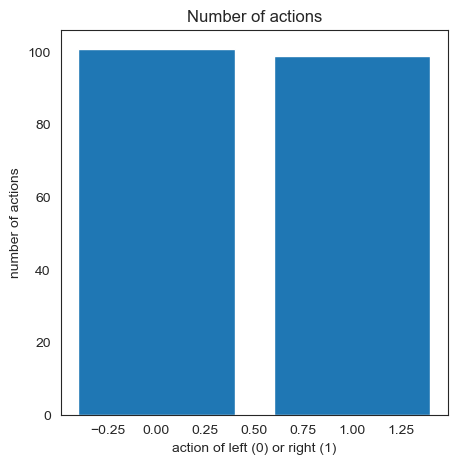

In [902]:
# Bar the number of actions 

def plot_actions_bar(choices):
    plt.figure(figsize=(5, 5))

    # count zeros and ones

    choices = np.array(choices)
    choices = np.bincount(choices)

    plt.bar([0,1], choices)
    plt.title('Number of actions')
    plt.xlabel('action of left (0) or right (1)')
    plt.ylabel('number of actions')

plot_actions_bar(choices)

## (BONUS) Introducing some Machine Learning

Planning on each iteration can be costly. You can speed things up drastically if you train a classifier to predict which action will turn out to be best according to MCTS.

>To do so, adapt the code and record which action did the MCTS agent take on each step and fit a classifier to [state, mcts_optimal_action]

# Model Learning:  Dyna-Q

> Implement a Tabular Dyna-Q algorithm ( Chapter 8.2 Barto-Sutton) for the Frozen Lake environment

!["Description of Dyna Algorithm"](dyna.png)

In [852]:
class DynaAgent:
    def __init__(self,env,epsilon=1e-3, alpha=0.1, gamma=0.99):
        """Step (a)"""
        self.n_actions = env.action_space.n
        self.n_states = env.observation_space.n
        self.epsilon =epsilon
        self.q = np.zeros((n_states,n_actions))
        self.model = np.zeros((n_states,n_actions,2)) # self.model[s,a] return r and s'
        self.env = env
        self.current_state,_ = env.reset()
        self.alpha = alpha
        self.gamma = gamma
        self.previously_observed_states = {self.current_state: set()}
         
    def choose(self):
        """Step (b)"""
        
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            best_actions = np.where(self.q[self.current_state] == np.max(self.q[self.current_state]))[0]
            action = np.random.choice(best_actions)

        self.previously_observed_states[self.current_state].add(action)
        
        return action
    

    def record_state(self, state):
        self.current_state = state
        if state not in self.previously_observed_states:
            self.previously_observed_states[state] = set()

    def observe(self,action):
        """Step (c)"""
        
        next_state, reward, done, truncated, _ = self.env.step(action)
        return next_state, reward, done, truncated


    
    def update_model(self,s1,a1,r1,s2):
        """Step (e)"""


        self.model[s1,a1]= [r1,s2]

        # print(self.model[s1,a1])
 
    def update_value(self,s1,a1,r1,s2):
        """Step (d)"""

        
        self.q[s1,a1] += self.alpha * (r1 + self.gamma * np.max(self.q[s2]) - self.q[s1,a1])


    def planning(self,n_steps):
        """Step (f)"""
        
        for _ in range(n_steps):
            s1 = np.random.choice(list(self.previously_observed_states.keys()))
            actions = self.previously_observed_states[s1]

            s1 = int(s1)
            
            if len(actions) != 0:
                a1 = np.random.choice(list(actions))
                a1 = int(a1)
                r1, s2 = self.model[s1,a1]

                # there is a chance that they are 0. 0.
                s2 = int(s2)
                r1 = int(r1)

                
                self.update_value(s1,a1,r1,s2)

In [853]:
def play_dyna(agent, n_steps=1000, n_planing_steps=5):
    
    for _ in range(n_steps):
        # print("Step", _)
        action = agent.choose()
        next_state, reward, done, truncated = agent.observe(action)
        agent.update_model(agent.current_state,action,reward,next_state)
        agent.update_value(agent.current_state,action,reward,next_state)
        agent.planning(n_planing_steps)
        agent.record_state(next_state)
        if done:
            state, _ = env.reset()
            agent.record_state(state)

    return agent 

In [854]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                             render_mode="ansi",
                             max_episode_steps=200, is_slippery=False))
dynaAgent = DynaAgent(env)


dynaAgent = play_dyna(dynaAgent, n_steps=5000, n_planing_steps=20)

> What are some limits of the algorithm ? Does it scale ? Explain. 

The learned "model" can be suboptimal and we can compute wrong policies. It is also very dependent on reaching the final goal (reward of 1) in order to update its policy correctly, otherwise it will walk in all directions. If we look in the plot which emphasies the number of decisions taken in each state, it can be noticed that it get lost in the nearby areas from the starting state. Without q-value updates, the choices will remain the same. There, it is less likely that the agent will scale well in envrionments of larger size. 

In [855]:
moves = {0: "L", 1: "D", 2: "R", 3: "U"}

solution = [np.argmax(dynaAgent.q[i]) for i in range(64)]
policy = np.array(solution).reshape(8,8)

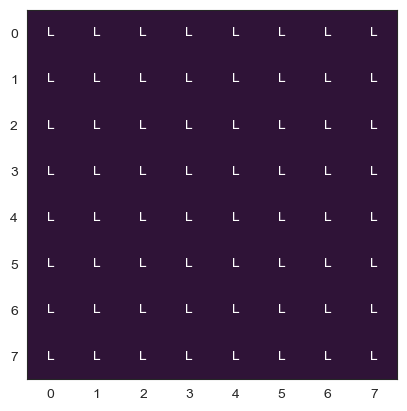

In [856]:
plt.imshow(policy, cmap='twilight_shifted')
for i in range(8):
    for j in range(8):
        plt.text(j, i, moves[policy[i, j]], ha="center", va="center", color="white")

In [857]:
visits = np.zeros((64))
for state, actions in dynaAgent.previously_observed_states.items():
    visits[state] = len(actions)

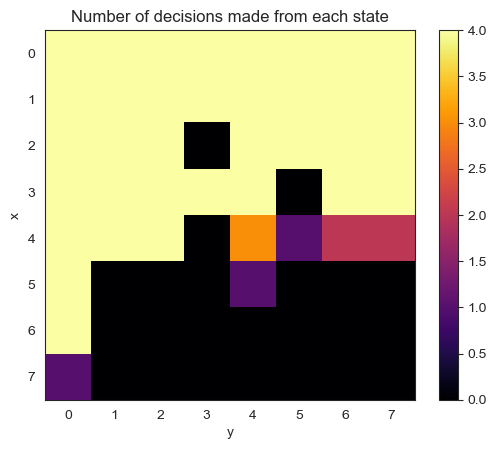

In [858]:
plt.imshow(visits.reshape(8,8), cmap='inferno')
plt.colorbar()
plt.xlabel("y")
plt.ylabel("x")
plt.title("Number of decisions made from each state")
plt.show()

### Let's force him a bit and increase the planing steps 

In [880]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                             render_mode="ansi",
                             max_episode_steps=300, is_slippery=False))

dynaAgent = DynaAgent(env)


dynaAgent = play_dyna(dynaAgent, n_steps=15000, n_planing_steps=200)

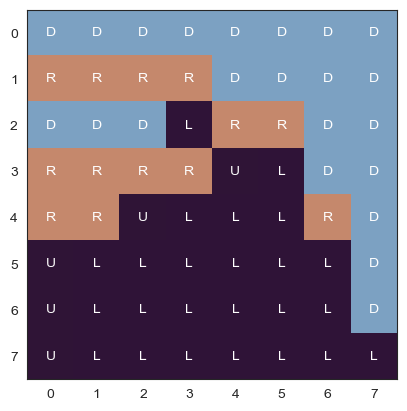

In [881]:

solution = [np.argmax(dynaAgent.q[i]) for i in range(64)]
policy = np.array(solution).reshape(8,8)

plt.imshow(policy, cmap='twilight_shifted')
for i in range(8):
    for j in range(8):
        plt.text(j, i, moves[policy[i, j]], ha="center", va="center", color="white")

Even like this, it barely reaches the states close to the finish line (and sometimes you need to run it multiple times)

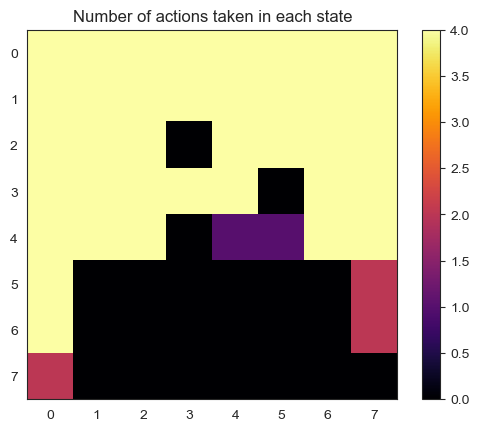

In [882]:
visits = np.zeros((64))
for state, actions in dynaAgent.previously_observed_states.items():
    visits[state] = len(actions)

plt.imshow(visits.reshape(8,8), cmap='inferno')
plt.colorbar()
plt.title("Number of actions taken in each state")
plt.show()

_Parts of the code for this practical has been inspired by https://github.com/yandexdataschool/Practical_RL/_